In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Useful function (1)
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [3]:
# Useful function (2)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [4]:
### MNIST ###

In [5]:
# Download the MNIST dataset from openml
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
# Split the data and put the test set aside
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], test_size=0.2, random_state=42)

In [7]:
X_train.shape

(56000, 784)

In [8]:
y_train.shape

(56000,)

In [9]:
X_test.shape

(14000, 784)

In [10]:
y_test.shape

(14000,)

In [11]:
y_train[0]

'5'

In [12]:
# Convert labels from strings to integers
y_train = y_train.astype(np.uint8)
y_test  = y_test.astype(np.uint8)

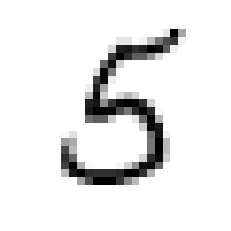

In [13]:
plot_digit(X_train[0])

In [14]:
y_train[0]

5

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

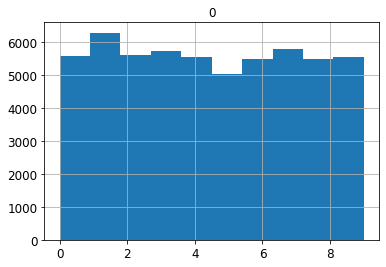

In [15]:
import pandas as pd

y_train_pd = pd.DataFrame(y_train)
y_train_pd.hist(bins=10)
# As you can see, the data is balanced

In [16]:
# Let's use TSNE for a better visualisation of the digits (in a 2D plane)

In [17]:
from sklearn.manifold import TSNE

# This cell takes ~5 minutes to run
tsne = TSNE(n_components=2, random_state=42)
X_train_red = tsne.fit_transform(X_train)

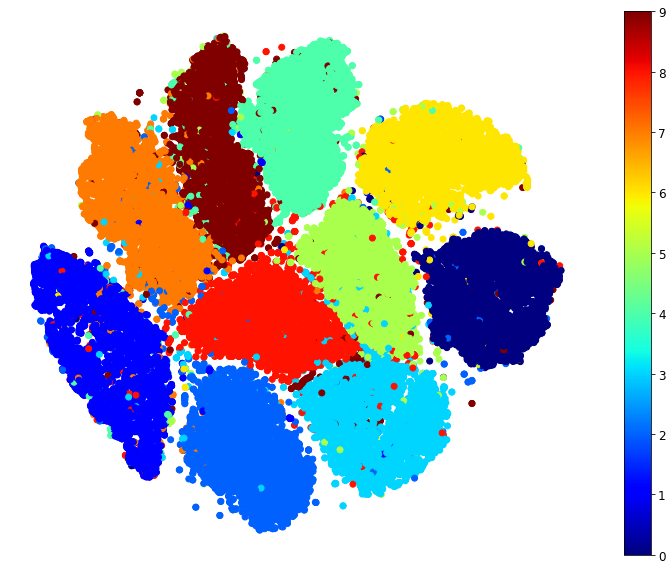

In [18]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different colors for each digit
plt.figure(figsize=(13, 10))
plt.scatter(X_train_red[:, 0], X_train_red[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()

In [19]:
# Let's try a multiclass classification algorithm

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [21]:
X_train_slice = X_train[:10000]
y_train_slice = y_train[:10000]

In [22]:
forest_clf.fit(X_train_slice, y_train_slice)

RandomForestClassifier(random_state=42)

In [23]:
from sklearn.metrics import accuracy_score

y_pred = forest_clf.predict(X_train[15000:20000])
accuracy_score(y_train[15000:20000], y_pred)

0.9502

In [24]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(forest_clf, X_train[15000:20000], y_train[15000:20000], cv=3, method="predict_proba")

In [25]:
y_pred_class = np.argmax(y_pred, axis=-1)
y_pred_class

array([6, 5, 2, ..., 2, 1, 5], dtype=int64)

In [26]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train[15000:20000], y_pred_class)
conf_mat

array([[481,   0,   1,   0,   0,   0,   4,   0,   3,   0],
       [  0, 544,   5,   2,   1,   2,   3,   0,   2,   2],
       [  3,   4, 469,   6,   7,   0,   5,   9,   2,   1],
       [  2,   2,  11, 458,   0,  15,   2,   5,   9,   5],
       [  1,   0,   3,   0, 441,   0,  10,   1,   3,  27],
       [  7,   2,   1,   8,   7, 390,   8,   1,   6,   7],
       [  6,   2,   6,   0,   3,  10, 485,   0,   2,   0],
       [  1,   1,   8,   0,   8,   0,   0, 496,   0,  11],
       [  4,   6,   5,  16,   3,   3,   1,   0, 433,   7],
       [  2,   0,   0,   8,  13,   2,   2,   9,   3, 456]], dtype=int64)

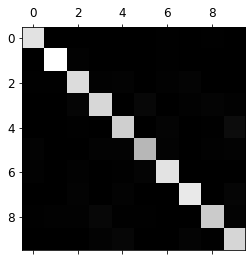

In [27]:
plt.matshow(conf_mat, cmap=plt.cm.gray)

In [28]:
# Let's focus the plot on the errors
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mat / row_sums
np.fill_diagonal(norm_conf_mx, 0)

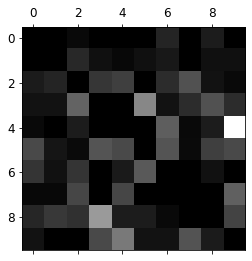

In [29]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Rows = real classes
# Cols = predicted classses

In [30]:
# Until now, we have the RandomForestClassifier with 95% score
# From conf_max_err we see that this model misclassify a lot of 4's as 9's

In [31]:
# Without modifying the data, let's try to fit another model which will misclassify other digits

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [33]:
knn_clf.fit(X_train[:10000], y_train[:10000])

KNeighborsClassifier()

In [34]:
y_pred_class = knn_clf.predict(X_train[15000:20000])
accuracy_score(y_train[15000:20000], y_pred_class)

0.9522

In [35]:
conf_mat = confusion_matrix(y_train[15000:20000], y_pred_class)
conf_mat

array([[483,   1,   0,   0,   0,   1,   4,   0,   0,   0],
       [  0, 555,   1,   1,   0,   0,   2,   1,   0,   1],
       [  3,  12, 476,   0,   2,   0,   1,   9,   2,   1],
       [  1,   1,   4, 484,   0,   7,   1,   5,   5,   1],
       [  2,  13,   0,   0, 453,   0,   3,   1,   0,  14],
       [  5,   2,   0,  11,   2, 405,   4,   2,   1,   5],
       [  6,   2,   0,   0,   0,   4, 502,   0,   0,   0],
       [  1,   9,   3,   0,   4,   0,   0, 504,   0,   4],
       [  3,   6,   5,  12,   2,  14,   0,   0, 431,   5],
       [  1,   0,   0,   5,   7,   1,   1,  11,   1, 468]], dtype=int64)

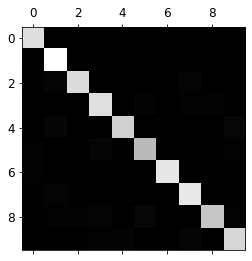

In [36]:
plt.matshow(conf_mat, cmap=plt.cm.gray)

In [37]:
# Let's focus the plot on the errors
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mat / row_sums

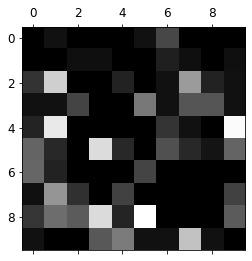

In [38]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Rows = real classes
# Cols = predicted classses

In [39]:
# We can see that this model missclasify the same 4's as 9's
# But, it does other mistakes

In [40]:
# Let's normalize the data (from [0, 255] to [0, 1])

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled  = scaler.transform(X_test.astype(np.float64))

In [42]:
# Let's see if we get an improvement

In [43]:
X_train_scaled.shape

(56000, 784)

In [44]:
X_train_slice = X_train_scaled[:10000]
y_train_slice = y_train[:10000]

In [45]:
# RandomForestClassifier
forest_clf.fit(X_train_slice, y_train_slice)

RandomForestClassifier(random_state=42)

In [46]:
y_pred = forest_clf.predict(X_train_scaled[15000:20000])
accuracy_score(y_train[15000:20000], y_pred)

0.9504

In [47]:
# KNeighborsClassifier
knn_clf.fit(X_train_slice, y_train_slice)

KNeighborsClassifier()

In [48]:
y_pred = knn_clf.predict(X_train_scaled[15000:20000])
accuracy_score(y_train[15000:20000], y_pred)

0.917

In [49]:
# There is no improvement in KNN

In [50]:
# Let's try the SGDClassifier

In [51]:
from sklearn.linear_model import SGDClassifier
# Always scale the input for SGDClassifier

sgd_clf = SGDClassifier()

In [52]:
sgd_clf.fit(X_train_slice, y_train_slice)

F:\anaconda3\envs\tf-keras-gpu\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGDClassifier()

In [53]:
y_pred = sgd_clf.predict(X_train_scaled[15000:20000])
accuracy_score(y_train[15000:20000], y_pred)

0.9104

In [54]:
# Therefore, we will use the raw data
# Let's make a grid search for finding the best parameters
# for each of those 2 models (RandomForestClassifier and KNeighborsClassifier)

In [55]:
# Until now, we have the data as follows:
# X_train, y_train, X_test, y_test (test = 20% * train)

In [56]:
n_estimators = [75, 100, 125]
max_features = ['auto', 'sqrt']

max_depth = [10, 50, 100]
max_depth.append(None)

min_samples_split = [2, 5, 10]

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
}

grid_search = GridSearchCV(forest_clf, param_grid, cv=3, n_jobs=-1, verbose=3)

In [58]:
grid_search.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [75, 100, 125]},
             verbose=3)

In [59]:
grid_search.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [60]:
best_model_pred = grid_search.best_estimator_.predict(X_test)

In [61]:
accuracy_score(y_test, best_model_pred)

0.9447857142857143

In [62]:
# Not an improvement

In [63]:
# So, we should stick to the base models
# Or, try a more complex grid search (or randomized grid search)

In [64]:
# Let's try this: best parameters found by using a grid search
# param_grid = [
#     {"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5]}
# ]
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")

In [65]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [66]:
y_pred_knn = knn_clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred_knn)

0.9731428571428572

In [68]:
# Let's try to combine the 'forest_clf' and 'knn_clf'

In [69]:
from sklearn.ensemble import VotingClassifier

estimators = [('forest', forest_clf), ('knn', knn_clf)]
ensemble = VotingClassifier(estimators, voting='soft')

In [70]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance'))],
                 voting='soft')

In [71]:
ensemble_pred = ensemble.predict(X_test)

In [72]:
accuracy_score(y_test, ensemble_pred)

0.9737857142857143

In [73]:
# We have the best predictor until now
best_model = ensemble
best_model

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance'))],
                 voting='soft')

In [74]:
# Let's try a sort of data augmentation

In [75]:
from scipy.ndimage.interpolation import shift

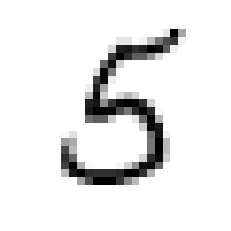

In [76]:
plot_digit(X_train[0])

In [77]:
def shift_image(image, dx=0, dy=0):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [78]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [79]:
len(X_train_augmented)

56000

In [80]:
# Augmentate data
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [81]:
# Transform in numpy array
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [82]:
X_train_augmented.shape

(280000, 784)

In [83]:
# Let's shuffle the data because when we did augmentation,
# original digit and 4 augmented images are placed consecutively
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [84]:
best_model.fit(X_train_augmented, y_train_augmented)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance'))],
                 voting='soft')

In [85]:
aug_pred = best_model.predict(X_test)

In [86]:
accuracy_score(y_test, aug_pred)
# 98.2% accuracy.. best results until now

0.982

In [87]:
# TODO: Rotate the original X_train samples
# ...

In [88]:
# Save the models for a later comparaison
import joblib

# joblib.dump(best_model, "mnist_model.pkl") (2.5GB)

# Later import
# lin_reg_imp = joblib.load("mnist_model.pkl")

In [89]:
### TITANIC DATASET ###

In [90]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()  

In [91]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    path = titanic_path + "\\" + filename
    return pd.read_csv(path)

In [92]:
train_data = load_titanic_data("train.csv")
test_data  = load_titanic_data("test.csv")

In [93]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [94]:
train_data.set_index("PassengerId", inplace=True)
test_data.set_index("PassengerId", inplace=True)

In [95]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [97]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [98]:
train_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [99]:
# Cabin attribute has a lot of NANs
# I think that the best option is to drop this feature

In [100]:
train_data.drop(columns=["Cabin"], inplace=True)
test_data.drop(columns=["Cabin"], inplace=True)

In [101]:
# Also, the ticket number is not relevant
train_data.drop(columns=["Ticket"], inplace=True)
test_data.drop(columns=["Ticket"], inplace=True)

In [102]:
# Also, the name of the passenger is not relevant
train_data.drop(columns=["Name"], inplace=True)
test_data.drop(columns=["Name"], inplace=True)

In [103]:
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [104]:
train_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

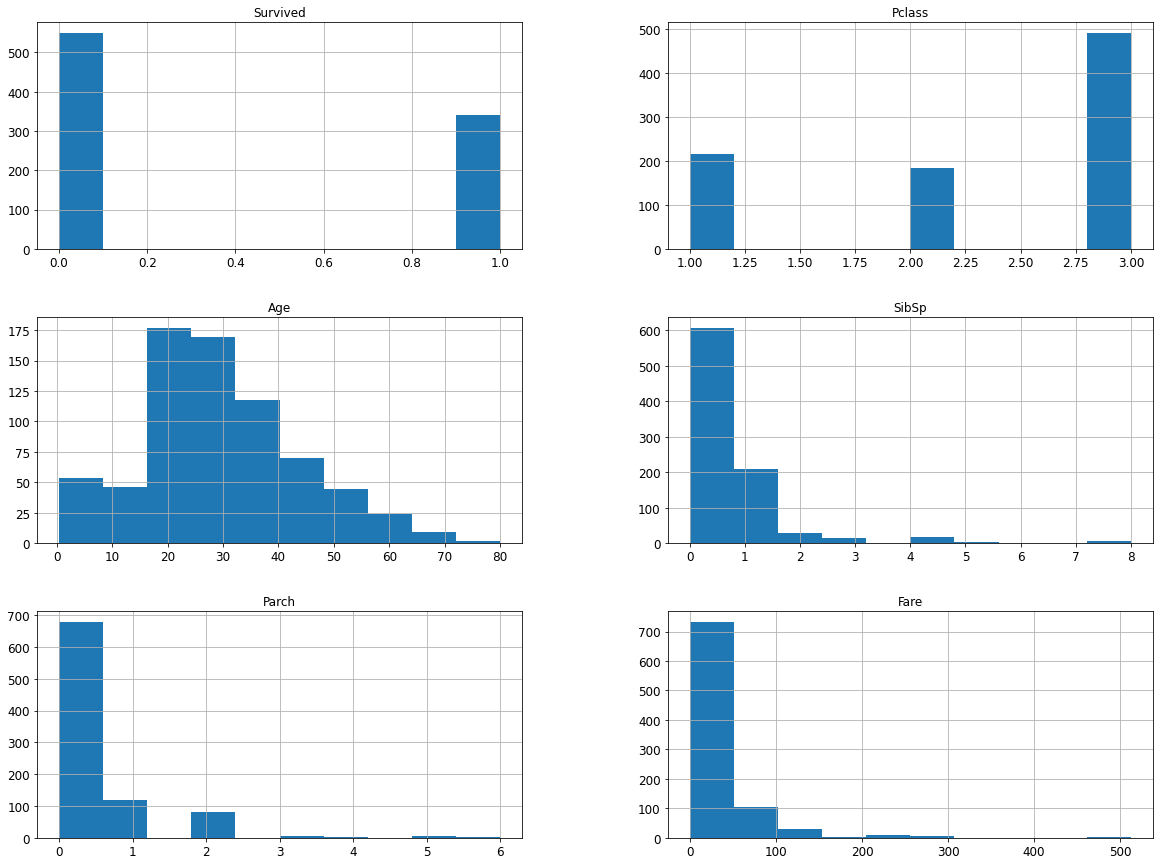

In [106]:
train_data.hist(figsize=(20,15))

In [107]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [108]:
train_data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [109]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)
# Fare is a good indicator

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [110]:
# Let's drop the labels from the dataset
y_train = train_data["Survived"]
y_train = np.asarray(y_train)
train_data.drop(columns=["Survived"], inplace=True)

In [111]:
y_train.shape

(891,)

In [112]:
train_data.shape

(891, 7)

In [113]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [114]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 55.7+ KB


In [115]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [116]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S


In [117]:
cat_attr = ["Sex", "Embarked"]
num_attr = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

In [119]:
cat_pipe = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")), # fill in missing values
    ('one_hot_enc', OneHotEncoder(sparse=False)), # encode the categorical attributes
])

In [120]:
num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy="mean")), # fill in missing values
    ('normalized', Normalizer()),
])

In [121]:
transformer = ColumnTransformer([
    ("num", num_pipe, num_attr),
    ("cat", cat_pipe, cat_attr),
])

In [122]:
X_train = transformer.fit_transform(train_data[num_attr + cat_attr])
X_test  = transformer.transform(test_data[num_attr + cat_attr])

In [123]:
X_train[0]

array([0.12832206, 0.94102848, 0.04277402, 0.        , 0.31011166,
       0.        , 1.        , 0.        , 0.        , 1.        ])

In [124]:
train_data.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.25,S


In [125]:
X_train.shape

(891, 10)

In [126]:
y_train.shape

(891,)

In [127]:
X_test.shape

(418, 10)

In [128]:
# Until now, we have:
# X_train, y_train, X_test

In [129]:
# Let's try a T-SNE visualization
from sklearn.manifold import TSNE

In [130]:
tsne = TSNE(n_components=2, n_iter=10000)

In [131]:
X_train_red = tsne.fit_transform(X_train)

In [132]:
X_train_red.shape

(891, 2)

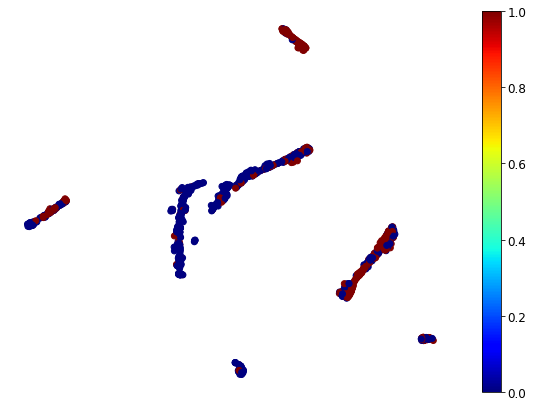

In [133]:
# Now let's use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit
plt.figure(figsize=(10, 7))
plt.scatter(X_train_red[:, 0], X_train_red[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()

In [134]:
X_train.shape

(891, 10)

In [135]:
y_train.shape

(891,)

In [136]:
from sklearn.model_selection import cross_val_score

In [137]:
from sklearn.svm import LinearSVC

In [138]:
linear_svc = LinearSVC() # with default hyperparameters

In [139]:
scores = cross_val_score(linear_svc, X_train, y_train, cv=10)
scores.mean()

0.7822596754057428

In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
knn = KNeighborsClassifier()

In [143]:
scores = cross_val_score(knn, X_train, y_train, cv=10)
scores.mean()

0.7710986267166042

In [145]:
from sklearn.linear_model import SGDClassifier

In [146]:
sgd = SGDClassifier()

In [147]:
scores = cross_val_score(sgd, X_train, y_train, cv=10)
scores.mean()

0.7733458177278403

In [149]:
from sklearn.svm import SVC

In [150]:
svc = SVC(gamma="auto")

In [151]:
scores = cross_val_score(sgd, X_train, y_train, cv=10)
scores.mean()

0.7406866416978777

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
forest = RandomForestClassifier()

In [155]:
scores = cross_val_score(forest, X_train, y_train, cv=10)
scores.mean()

0.7879151061173533

In [158]:
# TODO_1: Ensemble using 2-3 models (using VotingClassifier)
# TODO_2: Fine-tuning the best final model (using GridSearchCV)
# TODO_3: Process the data more